# Solving a Laplace problem with Dirichlet boundary conditions

### 利用Dirichlet 边界条件计算离子阱电势

步骤：
* 利用Gmsh制作电极排布，并划分2D网格，生成.msh文件。
  - 利用.geo脚本生成电极，注意需要用 physcial surface 标记不同电极的域    
    参考untitled.geo
* 导入msh文件，执行计算


### Implementation

We now demonstrate how to solve this problem with Bempp. We begin by importing Bempp and NumPy.

In [1]:
import bempp.api
import numpy as np

### Import the generated mesh

In [2]:
#grid = bempp.api.shapes.sphere(h=0.1)
grid = bempp.api.import_grid('needles2.msh')

We now define the <a href='https://bempp.com/2017/07/11/function-spaces/'>spaces</a>. For this example we will use two spaces: the space of continuous, piecewise linear functions; and the space of piecewise constant functions. The space of piecewise constant functions has the right smoothness for the unknown Neumann data. We will use continuous, piecewise linear functions to represent the known Dirichlet data.

In [3]:
dp0_space = bempp.api.function_space(grid, "DP", 0)
p1_space = bempp.api.function_space(grid, "P", 1)

We can now define the <a href='https://bempp.com/2017/07/11/operators/'>operators</a>. We need the identity, single layer, and double layer boundary operator.

In [4]:
identity = bempp.api.operators.boundary.sparse.identity(
    p1_space, p1_space, dp0_space)
dlp = bempp.api.operators.boundary.laplace.double_layer(
    p1_space, p1_space, dp0_space)
slp = bempp.api.operators.boundary.laplace.single_layer(
    dp0_space, p1_space, dp0_space)

We now define the <a href='https://bempp.com/2017/07/11/grid-functions/'>GridFunction object</a> on the sphere grid that represents the Dirichlet data.

In [5]:
i =0
def dirichlet_data(x, n, domain_index, result):
#     print(domain_index)
#     result[0] = 1./(4 * np.pi * ((x[0] - 1.5)**2 + x[1]**2 + x[2]**2)**(0.5))
    global i
    if domain_index in [1,2]:      # 在不同区域设置相应的电压
        result[0] = 300.0
        i+=1
#         print(domain_index)
    elif domain_index in [3,4,5,6]:
        result[0] = 0.0
    else:
        result[0] = 0.0
    
dirichlet_fun = bempp.api.GridFunction(p1_space, fun=dirichlet_data)
print i

11946


We next assemble the right-hand side of the boundary integral equation, given by $$(-\tfrac12\mathsf{Id}+\mathsf{K})u.$$

In [6]:
%time rhs = (-.5 * identity + dlp) * dirichlet_fun  # solve exterior
# rhs = (.5 * identity + dlp) * dirichlet_fun  # solve interior

CPU times: user 1min 42s, sys: 640 ms, total: 1min 43s
Wall time: 1min 18s


We now <a href='https://bempp.com/2017/07/12/solving-linear-systems/'>solve the linear system</a> using a conjugate gradient (CG) method.

In [7]:
%time neumann_fun, info = bempp.api.linalg.gmres(slp, rhs, tol=1E-3)

CPU times: user 46.3 s, sys: 1.04 s, total: 47.4 s
Wall time: 35.2 s


We now want to provide a simple plot of the solution in the $(x,y)$ plane for $z=0$. We first define points at which to plot the solution.

In [11]:
n_grid_points = 150
plot_grid = np.mgrid[-200:200:n_grid_points*1j, -200:200:n_grid_points*1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    np.zeros(plot_grid[0].size)))

The variable `points` now contains in its columns the coordinates of the evaluation points. We can now use Green's representation theorem to evaluate the solution on these points. Note in particular the last line of the following code. It is a direct implementation of Green's representation theorem.

In [12]:
%%time
slp_pot = bempp.api.operators.potential.laplace.single_layer(
    dp0_space, points)
dlp_pot = bempp.api.operators.potential.laplace.double_layer(
    p1_space, points)
u_evaluated = slp_pot * neumann_fun - dlp_pot * dirichlet_fun


CPU times: user 1min 22s, sys: 640 ms, total: 1min 23s
Wall time: 1min 1s


We now plot the 2D slice of the solution. For a full three dimensional visualization, Bempp can <a href='https://bempp.com/2017/07/12/import-and-export-of-gmsh-files/'>export the data to Gmsh</a>. Since the solution decays quickly, we use a logarithmic plot.

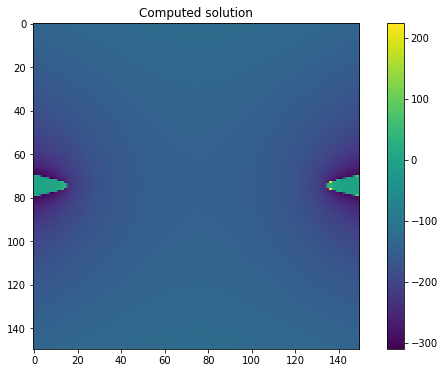

In [13]:
# The next command ensures that plots are shown within the IPython notebook
%matplotlib inline

import matplotlib
from matplotlib import pylab as plt
# import seaborn as sns


# Filter out solution values that are associated with points outside the unit circle.
u_evaluated = u_evaluated.reshape((n_grid_points,n_grid_points))
radius = np.sqrt(plot_grid[0]**2 + plot_grid[1]**2)
#u_evaluated[radius>1] = np.nan

# Plot the image

plt.figure(figsize=(10,6))
# cmap = sns.diverging_palette(220, 20, n=7,as_cmap=True)
# data = u_evaluated[n_grid_points/2-4:n_grid_points/2+40,n_grid_points/2-40:n_grid_points/2+40]
data = u_evaluated.T
plt.imshow(data,aspect=1.0)
plt.title('Computed solution')
plt.colorbar()

In [55]:
# bempp.api.export(grid=grid, file_name="sphere.msh")

NameError: name 'opts' is not defined

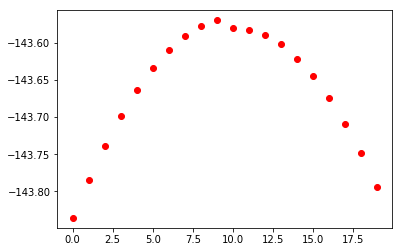

In [15]:
# import seaborn as sns
data = u_evaluated.T[n_grid_points/2,n_grid_points/2-10:n_grid_points/2+10]
plt.plot(data,'ro')

x = np.arange(len(data)/2)
opts1 = np.polyfit(x,data[:10],2)
opts2 = np.polyfit(x,data[10:],2)
print(opts[1]/opts[2],opts1, opts2) # 3阶与二阶的比值

(-0.0010848969262069546, array([  1.14293842e-07,  -1.42299437e-06,   1.31164016e-03,
        -2.48929575e-02,  -1.43462780e+02]))


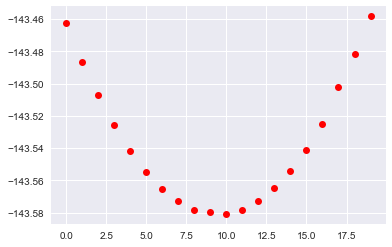

In [57]:
import seaborn as sns
data = u_evaluated.T[n_grid_points/2-10:n_grid_points/2+10,n_grid_points/2]
plt.plot(data,'ro')
x = np.arange(len(data))
opts = np.polyfit(x,data,4)
print(opts[1]/opts[2],opts) # 3阶与二阶的比值

In [ ]:
%%time
import datetime
print(datetime.datetime.now())

n_grid_points = 150
L = 50.0
dL = L/n_grid_points
plot_grid = np.mgrid[-L:L:n_grid_points*1j, -L:L:n_grid_points*1j,-L:L:n_grid_points*1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    plot_grid[2].ravel()))
slp_pot = bempp.api.operators.potential.laplace.single_layer(
    dp0_space, points)
dlp_pot = bempp.api.operators.potential.laplace.double_layer(
    p1_space, points)
u_evaluated = slp_pot * neumann_fun - dlp_pot * dirichlet_fun

print(datetime.datetime.now())

In [ ]:
u3D =u_evaluated.reshape(((n_grid_points,n_grid_points,n_grid_points)))
Ex, Ey, Ez = np.gradient(u3D)

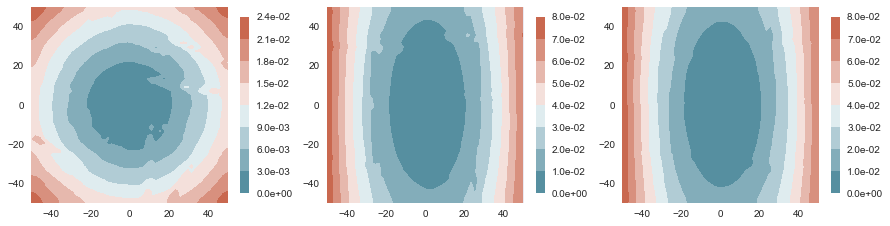

In [28]:
fig, axarr = plt.subplots(1,3,figsize=(15,3.6))

from scipy.constants import m_n, m_p, m_u,e, electron_volt, pi
from scipy import ndimage

omega = 25e6*2*pi

U_eff = e**2*(Ex**2+Ey**2+Ez**2)/(4*171*m_n*omega**2)/(dL*1e-6)**2 /electron_volt  # L unit is um 

ax,ay = np.mgrid[-L:L:n_grid_points*1j, -L:L:n_grid_points*1j]
cmap = sns.diverging_palette(220, 20, n=7,as_cmap=True)


# dat= ndimage.zoom(U_eff[25], 3)
a = axarr[0].contourf(ax,ay,U_eff[25],cmap=cmap)
axarr[0].grid()
axarr[0].axis('equal')
fig.colorbar(a, ax=axarr[0], shrink=0.9, format='%1.1e')

a = axarr[1].contourf(ax,ay,U_eff[:,25,:],cmap=cmap)
axarr[1].grid()
axarr[1].axis('equal')
fig.colorbar(a, ax=axarr[1], shrink=0.9, format='%1.1e')

a = axarr[2].contourf(ax,ay,U_eff[:,:,25],cmap=cmap)
axarr[2].grid()
axarr[2].axis('equal')
fig.colorbar(a, ax=axarr[2], shrink=0.9, format='%1.1e')

# a = axarr[1].imshow(U_eff[:,25,:],cmap=cmap)
# axarr[1].grid()

# a = axarr[2].imshow(U_eff[:,:,25],cmap=cmap)
# axarr[2].grid()
# a.colorbar()


In [255]:
# change ticks

# import numpy
# import matplotlib.pyplot as plt

# fig, (ax1, ax2) = plt.subplots(1,2)

# x1, x2 = 1, 5
# y1, y2 = 3, 7

# # first axis: ticks spaced at 0.5
# ax1.plot([x1, x2], [y1, y2])
# ax1.set_xticks(numpy.arange(x1-1, x2+1, 0.5))
# ax1.set_yticks(numpy.arange(y1-1, y2+1, 0.5))

# # second axis: tick labels will be replaced
# ax2.plot([x1, x2], [y1, y2])
# ax2.set_xticks(numpy.arange(x1-1, x2+1, 0.5))
# ax2.set_yticks(numpy.arange(y1-1, y2+1, 0.5))

# # We need to draw the canvas, otherwise the labels won't be positioned and 
# # won't have values yet.
# fig.canvas.draw()

# # new x ticks  '1'->'', '1.5'->'1', '2'->'', '2.5'->'2' etc.
# labels = [item.get_text() for item in ax2.get_xticklabels()]
# new_labels = [ "%d" % int(float(l)) if '.5' in l else '' for l in labels]
# ax2.set_xticklabels(new_labels)

# # new y ticks
# labels = [item.get_text() for item in ax2.get_yticklabels()]
# new_labels = [ "%d" % int(float(l)) if '.5' in l else '' for l in labels]
# ax2.set_yticklabels(new_labels)

# fig.canvas.draw()
# plt.show()

In [268]:
scipy.version.full_version

'0.18.1'

In [211]:
electron_volt

1.6021766208e-19

In [ ]:
help()


Welcome to Python 2.7!  This is the online help utility.

If this is your first time using Python, you should definitely check out
the tutorial on the Internet at http://docs.python.org/2.7/tutorial/.

Enter the name of any module, keyword, or topic to get help on writing
Python programs and using Python modules.  To quit this help utility and
return to the interpreter, just type "quit".

To get a list of available modules, keywords, or topics, type "modules",
"keywords", or "topics".  Each module also comes with a one-line summary
of what it does; to list the modules whose summaries contain a given word
such as "spam", type "modules spam".

